In [1]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

data_dir = os.path.join("../../data/embeddings/")
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, plot=True):
    """
    Evaluate regression predictions for IMD rank.
    
    Parameters:
    - y_true: array-like, true IMD ranks
    - y_pred: array-like, predicted IMD ranks
    - plot: bool, whether to show scatter plot of predicted vs actual
    
    Returns:
    - metrics: dictionary with RMSE, MAE, R2, Spearman correlation
    """
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    print("Model evaluation metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel("True IMD Rank")
        plt.ylabel("Predicted IMD Rank")
        plt.title("Predicted vs Actual IMD Rank")
        plt.grid(True)
        plt.show()

    return metrics

### Get imd data

In [2]:
imd = pd.read_excel(imd_file, sheet_name="IoD2019 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2011)": "LSOA11CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

# 1. Using mean embedding at each location
### Get data 

In [3]:
avg_embeddings_per_location = pd.read_pickle(data_dir +"mean_embeddings_per_location.pkl")
avg_embeddings_per_location_with_imd = pd.merge(left=avg_embeddings_per_location, right=imd, on="LSOA11CD")

In [5]:
len(avg_embeddings_per_location_with_imd)

18897

### Build model

Model evaluation metrics:
RMSE: 8335.419
MAE: 7036.674
R2: 0.292
Spearman_rank_corr: 0.542


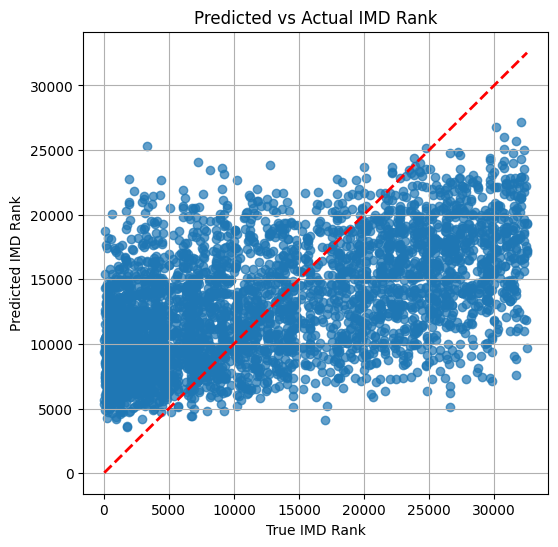

In [5]:
X = np.stack(avg_embeddings_per_location_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_per_location_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)

# 2. Using mean embedding per LSOA, based on mean each location

### Get data

In [7]:
avg_embeddings = pd.read_pickle(data_dir +"mean_embeddings_per_lsoa_from_mean.pkl")
avg_embeddings_with_imd = pd.merge(left=avg_embeddings, right=imd, on="LSOA11CD")

### Build model

Model evaluation metrics:
RMSE: 5843.716
MAE: 4696.391
R2: 0.630
Spearman_rank_corr: 0.763


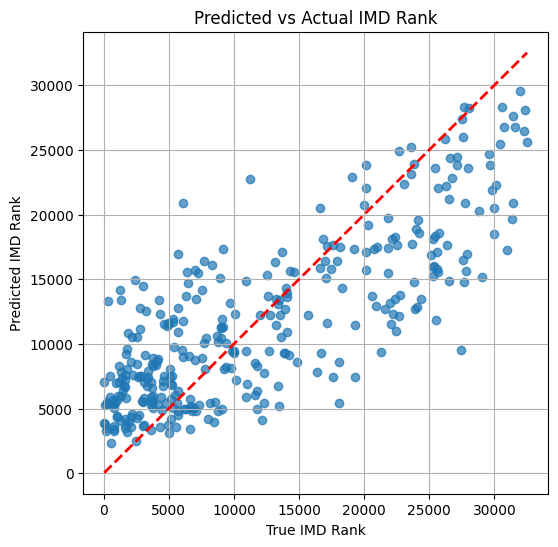

In [8]:
X = np.stack(avg_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)

# 3. Using mean embedding per LSOA, based on 4 images each location

### Get data

In [24]:
avg_embeddings = pd.read_pickle(data_dir +"mean_embeddings_per_lsoa.pkl")
avg_embeddings_with_imd = pd.merge(left=avg_embeddings, right=imd, on="LSOA11CD")

### Build model

Model evaluation metrics:
RMSE: 5437.299
MAE: 4233.568
R2: 0.680
Spearman_rank_corr: 0.798


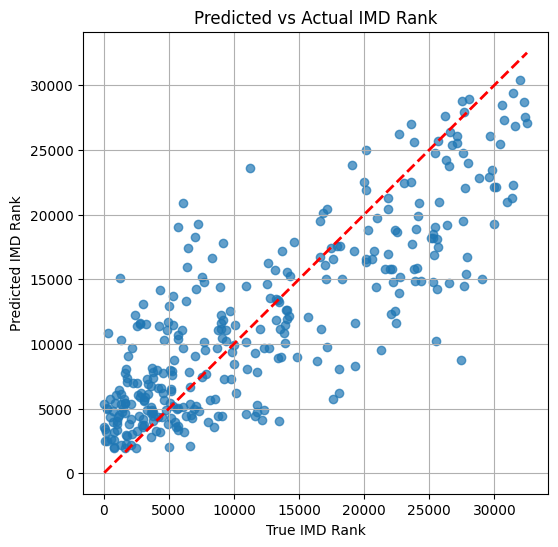

{'RMSE': 5437.298529666758, 'MAE': 4233.5678232158725, 'R2': 0.6795087114157257, 'Spearman_rank_corr': 0.7976719413130174}


In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X and y are already defined
X = np.stack(avg_embeddings_with_imd["embedding"].values)  # shape (n_points, embed_dim)
y = avg_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit an XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)

# Evaluate performance
metrics = evaluate_imd_model(y_test, y_pred)
print(metrics)


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# ==============================
# 1. Prepare data
# ==============================
X = np.stack(avg_embeddings_with_imd["embedding"].values)
y = avg_embeddings_with_imd['imd_rank'].values

# Split to avoid leakage (CV happens within training set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================
# 2. Define experimental settings
# ==============================
settings = [
    {"name": "No PCA + Default", "use_pca": False, "tuned": False},
    {"name": "No PCA + Tuned", "use_pca": False, "tuned": True},
    {"name": "PCA + Default", "use_pca": True, "tuned": False},
    {"name": "PCA + Tuned", "use_pca": True, "tuned": True},
]

# ==============================
# 3. Define models
# ==============================
default_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

tuned_params = dict(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    reg_lambda=3,
    reg_alpha=0.5,
    random_state=42,
    objective='reg:squarederror'
)

# ==============================
# 4. Run experiments
# ==============================
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for setting in settings:
    X_train_proc = X_train.copy()
    
    # Optional PCA
    if setting["use_pca"]:
        pca = PCA(n_components=100, random_state=42)
        X_train_proc = pca.fit_transform(X_train_proc)
    
    # Scale features
    scaler = StandardScaler()
    X_train_proc = scaler.fit_transform(X_train_proc)
    
    # Select parameters
    params = tuned_params if setting["tuned"] else default_params
    model = XGBRegressor(**params)
    
    # Cross-validation
    scores = cross_val_score(model, X_train_proc, y_train, cv=kf, scoring='r2', n_jobs=-1)
    
    results.append({
        "Experiment": setting["name"],
        "Mean R²": np.mean(scores),
        "Std R²": np.std(scores),
    })

# ==============================
# 5. Summarise results
# ==============================
results_df = pd.DataFrame(results).sort_values("Mean R²", ascending=False)
print(results_df)


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGB

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGB

         Experiment   Mean R²    Std R²
1    No PCA + Tuned  0.600147  0.025944
0  No PCA + Default  0.598468  0.029519
2     PCA + Default  0.554645  0.018194
3       PCA + Tuned  0.537983  0.026509


Model evaluation metrics:
RMSE: 5846.944
MAE: 4686.169
R2: 0.629
Spearman_rank_corr: 0.762


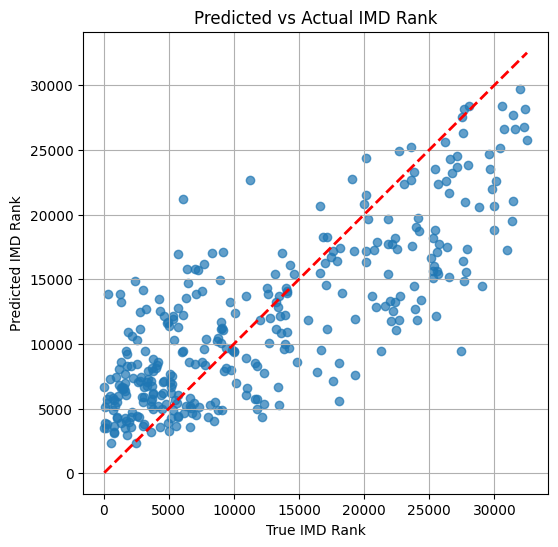

In [15]:
X = np.stack(avg_embeddings_with_imd["embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)

# 4. Using mean embedding for each cluster, in each LSOA
Did some testing, and model performance was improved by not reducing embedding length with PCA.  
But, the more clusters were used, the worse the performance (not exactly, but generally a downwards trend)

### Get data 

In [14]:
avg_weighted_embeddings_per_cluster = pd.read_pickle(data_dir +"global_clusters_weighted_mean_embeddings.pkl")
avg_weighted_embeddings_per_cluster_with_imd = pd.merge(left=avg_weighted_embeddings_per_cluster, right=imd[['imd_rank', 'LSOA11CD']], on="LSOA11CD")

### Run model

Model evaluation metrics:
RMSE: 5846.944
MAE: 4686.169
R2: 0.629
Spearman_rank_corr: 0.762


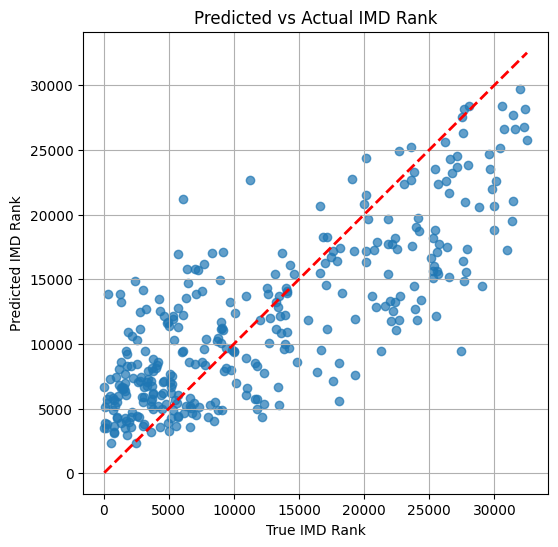

{'RMSE': 5846.943919781978, 'MAE': 4686.16877245509, 'R2': 0.629398024791824, 'Spearman_rank_corr': 0.7622996846162456}


In [20]:
X = np.vstack(avg_weighted_embeddings_per_cluster_with_imd['weighted_embedding'].values)

# Target
y = avg_weighted_embeddings_per_cluster_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf.predict(X_test)
metrics = evaluate_imd_model(y_test, y_pred)
print(metrics)

# 5. Using mean embedding for each cluster, in each LSOA
Did some testing, and model performance was improved by not reducing embedding length with PCA.  
But, the more clusters were used, the worse the performance (not exactly, but generally a downwards trend)

In [26]:
avg_weighted_embeddings_per_cluster = pd.read_pickle(data_dir +"xml.pkl")

In [28]:
avg_weighted_embeddings_per_cluster_with_imd = pd.merge(left=avg_weighted_embeddings_per_cluster, right=imd[['imd_rank', 'LSOA11CD']], on="LSOA11CD")

Model evaluation metrics:
RMSE: 6814.752
MAE: 5648.422
R2: 0.497
Spearman_rank_corr: 0.676


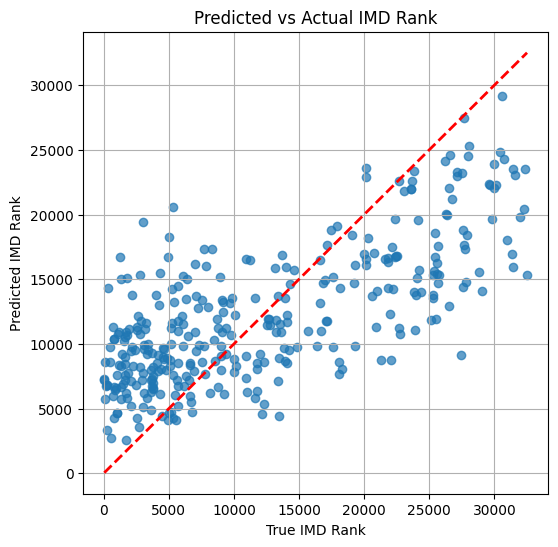

{'RMSE': 6814.751988243432, 'MAE': 5648.421676646706, 'R2': 0.49655737529176946, 'Spearman_rank_corr': 0.6757230194713438}


In [32]:
# Features: drop LSOA11CD and imd_rank columns
X = avg_weighted_embeddings_per_cluster_with_imd.drop(columns=['LSOA11CD', 'imd_rank']).values

# Target
y = avg_weighted_embeddings_per_cluster_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf.predict(X_test)
metrics = evaluate_imd_model(y_test, y_pred)
print(metrics)



Model evaluation metrics:
RMSE: 6429.197
MAE: 5214.063
R2: 0.552
Spearman_rank_corr: 0.708


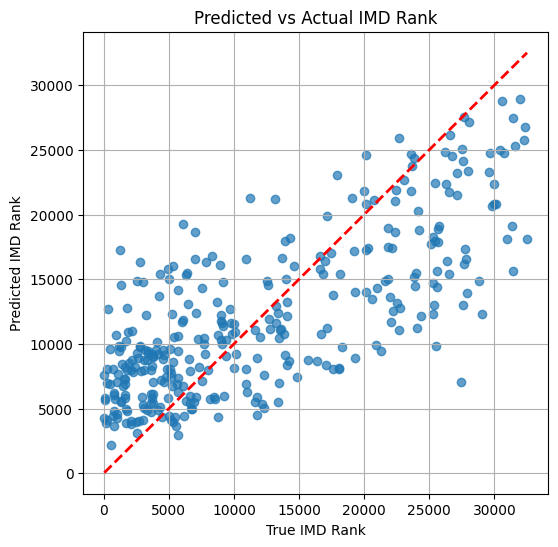

In [17]:
X = np.stack(avg_embeddings_per_cluster_with_imd["weighted_embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_per_cluster_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)